In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.utils import coalesce, to_dense_adj, to_undirected
from vitRet.data.fundus import EyePACSDataModule

In [12]:
data_dir = '/home/clement/Documents/data/eyepacs/'
datamodule = EyePACSDataModule(data_dir=data_dir, num_workers=4, batch_size=3, superpixels_scales=1, 
                               superpixels_min_nb=12, 
                               img_size=(32, 32),
                               superpixels_filter_black=True)
datamodule.setup('test')
dataloader = datamodule.test_dataloader()
batch = next(iter(dataloader))

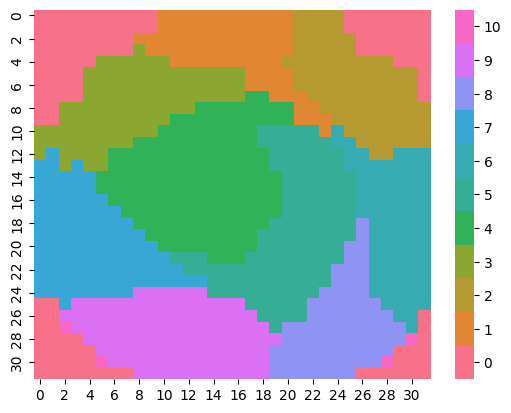

In [23]:
import seaborn as sns

segments = batch['segments']
b_index = 0
n = segments[b_index].amax()
cmap = sns.color_palette("husl", n) 
ax = sns.heatmap(segments[b_index, 0], linewidth=0, cmap=cmap)

colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(range(n))   

plt.show()

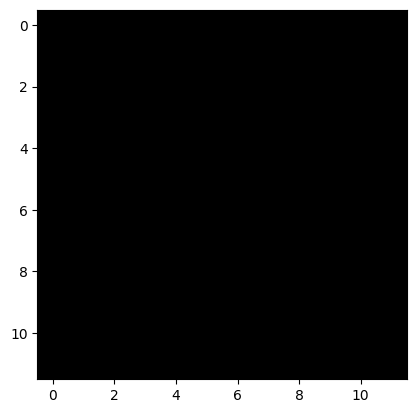

: 

In [38]:

torch.compile()
def get_adjacency_matrix(segments):
    n_number = torch.amax(segments) + 1
    h, w = segments.shape[-2:]
    w = w - 1
    b = segments.shape[0]
    batch = torch.arange(0, b, 1, device=segments.device).repeat_interleave(h*w)
    kernel = torch.zeros(2,1,1,2).float().cuda()
    kernel[0, :, :, 0] = 1
    kernel[1, :, :, 1] = 1
    borders = F.conv2d(segments.float(), kernel, padding=(0,0)).long()
    edge_index = borders.permute(1, 0,2,3).reshape(2, -1)
    adj = to_dense_adj(edge_index, batch=batch, max_num_nodes=n_number, batch_size=b)
    adj = adj + adj.permute(0, 2, 1) - torch.eye(adj.shape[1], device=adj.device)
    # adj[:, torch.eye(adj.shape[1], device=adj.device, dtype=torch.bool)] = 0
    return adj    

segments = segments.cuda()

adj = get_adjacency_matrix(segments)

plt.imshow(adj[2].cpu()>0)

In [33]:
2976/3

992.0